In [83]:
import numpy as np
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import sys
sys.path.append("../../utilities/")
import data_utils
import evaluation_utils
import seaborn as sns
import umap
import math
from sklearn import metrics
from matplotlib import pyplot as plt
sys.path.append("../../src")
from dataset_class import dataset
from importlib import reload
evaluation_utils = reload(evaluation_utils)
from hmmlearn import hmm

In [66]:
GM12878_signals_names = ['DNase', 'H3K4me2', 'H3K27ac', 'H2A.Z', 'H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K36me3', 'H3K79me2', 'H4K20me1']
GM12878_dataset = dataset('GM12878', 'hg19', 100000, '../../data/GM12878/hg19/Hi-C/GSE63525_GM12878_insitu_primary_30.hic',
                 '../../utilities/juicer_tools_1.22.01.jar', '../../data/GM12878/hg19/Hi-C/res100000',
                 GM12878_signals_names, '../../data/GM12878/hg19/genomic-assays/bin_100000/', 
                  '../../data/GM12878/hg19/res100000_datasets/',
                  '../../data/', '../../utilities/config.json')
GM12878_dataset.load_pos2ind_and_ind2pos_maps('../../data/valid_bins/hg19/GM12878_100000_bins.txt')

In [77]:
gene_expression_path = '../../data/GM12878/hg19/gene_expression/GM12878_genes_RPKM.txt'
RT_path = '../../data/GM12878/hg19/RT/six_phase/six_phases.txt'

In [21]:
map_10k_to_100k = data_utils.align_two_resolution('../../data/valid_bins/hg19/GM12878_10000_bins.txt',
                    '../../data/valid_bins/hg19/GM12878_100000_bins.txt', 10000, 100000)

In [41]:
signals_path = {10000: '../../data/GM12878/hg19/res10000_datasets/signals.txt',
               25000: '../../data/GM12878/hg19/res25000_datasets/signals.txt',
               100000: '../../data/GM12878/hg19/res100000_datasets/signals.txt'}
signals = {}
for res in [10000,25000,100000]:
    signals[res] = np.loadtxt(signals_path[res])

In [ ]:
'''
for res in [10000, 25000, 100000]:
    labels_df = pd.DataFrame()
    for k in np.arange(2,16):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(signals[res])
        l = kmeans.labels_
        labels_df['kmeans_{}'.format(k)] = l
    labels_df.to_csv('results/kmeans_res{}.txt'.format(res), sep = "\t", index = False)
    
for res in [10000, 25000, 100000]:
    labels_df = pd.DataFrame()
    for k in np.arange(2,16):
        gmm = GaussianMixture(n_components=k, random_state=0).fit(signals[res])
        l = gmm.predict(signals[res])
        labels_df['GMM_{}'.format(k)] = l
    labels_df.to_csv('results/GMM_res{}.txt'.format(res), sep = "\t", index = False)
    
lengths = GM12878_dataset.get_chunks_lengths()
labels_df = pd.DataFrame()
for k in np.arange(2,16):
    gmm_hmm_viterbi = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
    gmm_hmm_viterbi.fit(signals[100000], lengths)
    gmm_hmm_viterbi_labels = gmm_hmm_viterbi.predict(signals[100000], lengths)
    labels_df['HMM_viterbi_{}'.format(k)] = gmm_hmm_viterbi_labels
labels_df.to_csv('results/HMM_viterbi_res{}.txt'.format(res), sep = "\t", index = False)
'''
kmeans_labels = {}
GMM_labels = {}
for res in [10000, 25000, 100000]:
    kmeans_labels[res] = pd.read_csv('results/kmeans_res{}.txt'.format(res), sep = "\t")
    GMM_labels[res] = pd.read_csv('results/GMM_res{}.txt'.format(res), sep = "\t")
    
'''
for res in [100000]:
    for k in np.arange(2,16):
        GM12878_dataset.write_annotation(kmeans_labels[res]['kmeans_{}'.format(k)], 
                                         'kmeans_{}'.format(k), 'results/kmeans_{}/'.format(res))
        GM12878_dataset.write_annotation(GMM_labels[res]['GMM_{}'.format(k)], 
                                         'GMM_{}'.format(k), 'results/GMM_{}/'.format(res))
'''

In [86]:
labels_df = pd.DataFrame()
for k in np.arange(2,16):
    gmm_hmm_map = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='map')
    gmm_hmm_map.fit(signals[100000], lengths)
    gmm_hmm_map_labels = gmm_hmm_map.predict(signals[100000], lengths)
    labels_df['HMM_map_{}'.format(k)] = gmm_hmm_map_labels
labels_df.to_csv('results/HMM_map_res{}.txt'.format(res), sep = "\t", index = False)

In [72]:
kmeans_ge_ve = []
GMM_ge_ve = []
for k in np.arange(2,16):
    kmeans_ge_ve.append(evaluation_utils.gene_expression_ve('../../data/GM12878/hg19/gene_expression/GM12878_genes_RPKM.txt',
                                       'results/kmeans_100000/kmeans_{}_annotation.txt'.format(k), 100000))
    GMM_ge_ve.append(evaluation_utils.gene_expression_ve('../../data/GM12878/hg19/gene_expression/GM12878_genes_RPKM.txt',
                                       'results/GMM_100000/GMM_{}_annotation.txt'.format(k), 100000))

<AxesSubplot:>

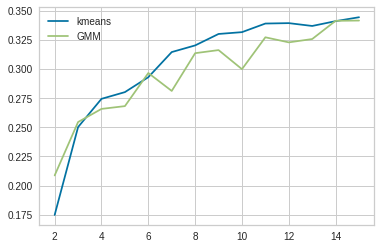

In [76]:
sns.lineplot(x=np.arange(2,16), y=kmeans_ge_ve, label = 'kmeans')
sns.lineplot(x=np.arange(2,16), y=GMM_ge_ve, label = 'GMM')

In [79]:
evaluation_utils.RT_scores(RT_path, 'results/kmeans_100000/kmeans_{}_annotation.txt'.format(4), 100000)

(0.19986079732539344, 0.08780748234029506)

In [80]:
evaluation_utils.RT_scores(RT_path, 'results/GMM_100000/GMM_{}_annotation.txt'.format(4), 100000)

(0.29532682937118154, 0.16897270162292807)

In [34]:
embedding = umap.UMAP().fit_transform(signals[100000])

In [48]:
signal = pd.DataFrame(signals[100000])
signals_names = ['DNase', 'H3K4me2', 'H3K27ac', 'H2A.Z', 'H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K36me3', 'H3K79me2', 'H4K20me1']
signal.columns = signals_names
signals_labels = pd.concat([signal,kmeans_labels[100000]], axis = 1)
signals_labels = pd.concat([signals_labels,GMM_labels[100000]], axis = 1)
signals_labels['umap1'] = embedding[:,0]
signals_labels['umap2'] = embedding[:,1]

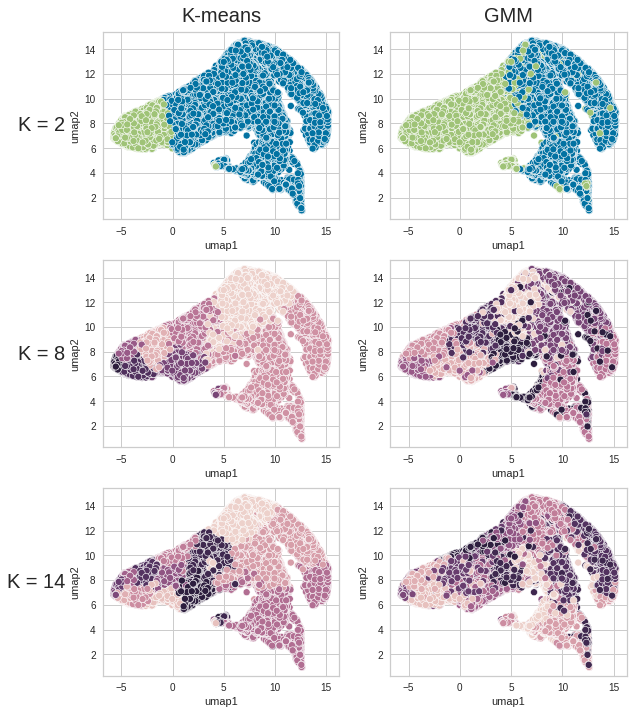

In [57]:
fig, axs = plt.subplots(3,2, figsize = (9,10))
for l,num_label in enumerate([2,8,14]):
    sns.scatterplot(data=signals_labels, x = 'umap1', y = 'umap2', hue = 'kmeans_{}'.format(num_label), ax = axs[l,0], legend = False)
    sns.scatterplot(data=signals_labels, x = 'umap1', y = 'umap2', hue = 'GMM_{}'.format(num_label), ax = axs[l,1], legend = False)

pad = 1
for ax, col in zip(axs[0], ['K-means', 'GMM']):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 10*pad),
                xycoords='axes fraction', textcoords='offset pixels',
                size=20, ha='center', va='baseline')

for ax, row in zip(axs[:,0], ['K = {}'.format(k) for k in [2,8,14]]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset pixels',
                size=20, ha='right', va='center')

fig.tight_layout(pad=1.0)

In [62]:
evaluation_utils.within_cluster_SSE(signals[100000],GMM_labels[100000]['GMM_5'])

38623.98336896948

In [8]:
np.unique(kmeans_labels[10000].loc[:,'kmeans_5'], return_counts = True)

(array([0, 1, 2, 3, 4]), array([ 27701, 215372,   5177,   3061,  13154]))

In [48]:
labels_100k = get_subset(kmeans_labels[100000]['kmeans_5'].values, map_10k_to_100k['index2'])
labels_10k = kmeans_labels[10000].loc[:,'kmeans_5'].values

In [49]:
aligned_labels = get_aligned_labels(kmeans_labels[10000]['kmeans_5'].values, kmeans_labels[100000]['kmeans_5'].values, map_10k_to_100k)

In [51]:
metrics.adjusted_rand_score(aligned_labels['label1'], aligned_labels['label2'])

0.46860857082256957

In [5]:
np.unique(kmeans_labels[100000]['kmeans_5'], return_counts = True)

(array([0, 1, 2, 3, 4]), array([ 5312, 17967,   829,   430,  2190]))

In [12]:
signals_labels

,DNase,H3K4me2,H3K27ac,H2A.Z,H3K9me3,H3K4me1,H3K27me3,H3K9ac,H3K4me3,H3K36me3,...,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10,kmeans_11,kmeans_12,kmeans_13,kmeans_14,kmeans_15
0,0.469453,0.035021,0.022692,0.043498,0.038646,0.034715,0.057225,0.037046,0.033846,0.029628,...,3,1,2,1,0,3,0,6,6,3
1,0.619823,0.655245,0.632821,0.364142,0.330402,0.489236,0.207846,0.779254,0.603414,0.750826,...,0,5,3,8,7,7,5,1,13,12
2,0.882458,1.381431,0.516599,0.667714,0.560807,0.989645,1.116711,0.999435,0.819625,0.712699,...,0,0,3,0,5,8,2,5,12,13
3,1.431842,3.165780,1.580747,1.076784,0.695534,2.088393,0.753637,1.765766,1.354412,0.687397,...,5,4,1,3,6,10,6,11,11,10
4,0.858569,1.452595,0.684815,0.932022,0.807067,1.096360,0.499303,1.028794,0.665272,0.520135,...,0,0,3,0,2,8,2,5,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26723,0.798077,0.354824,0.736900,0.270203,0.360560,0.663456,0.283219,0.579724,0.387581,2.580795,...,1,5,5,8,7,7,5,1,13,7
26724,3.749994,3.908150,6.073933,1.181823,0.427844,2.076663,0.534206,4.905733,2.008663,1.047651,...,2,2,4,4,4,2,7,10,10,9
26725,1.717940,1.912717,1.706367,0.933799,0.493790,1.047877,0.844005,1.964529,1.237551,0.899316,...,1,4,1,3,2,10,6,11,11,10
26726,0.579088,0.424478,0.413210,0.469643,0.486458,0.534791,0.932376,0.419562,0.426780,0.255899,...,3,1,0,5,3,5,3,0,0,5


/home/nedooshki/miniconda3/envs/embedding/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='H2A.Z', ylabel='Density'>

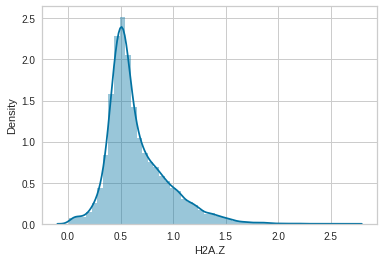

In [40]:
sns.distplot(signals['H2A.Z'])

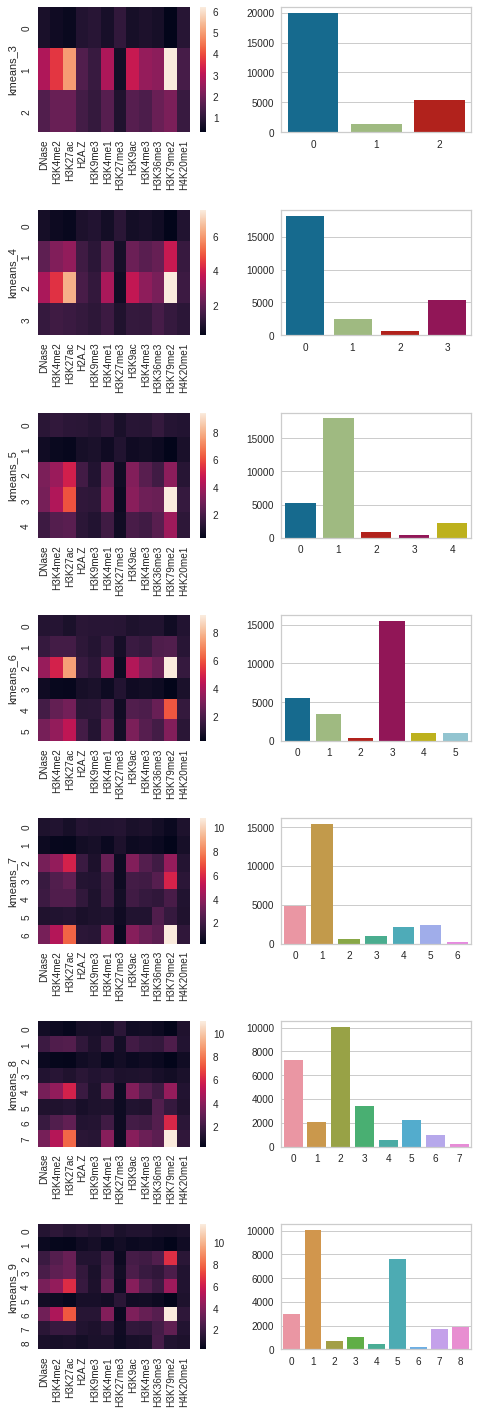

In [22]:
fig, axs = plt.subplots(7,2, figsize = (7,20))
for l, labels in enumerate(np.arange(3,10)):
    sns.heatmap(evaluation_utils.enrichment_scores_(signals_labels, signals_names, 'kmeans_{}'.format(labels)), ax = axs[l,0])
    sns.barplot(x = np.unique(signals_labels['kmeans_{}'.format(labels)], return_counts = True)[0],
               y = np.unique(signals_labels['kmeans_{}'.format(labels)], return_counts = True)[1], ax = axs[l,1])
fig.tight_layout(pad=2.0)

<AxesSubplot:>

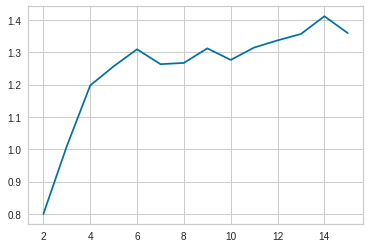

In [37]:
sns.lineplot(x = np.arange(2,16), y = [scores['DB', i] for i in np.arange(2,16)])